### 記事本
#### I. 需要解決的問題
* 處理 Imbalance 問題
* Table test
* 做 Cross Validation
* 嘗試使用 LightGBM
* 嘗試做 feature selection 後，再做 SMOTE -> t-SNE
#### II. 寫報告的流程
1. 先點出樣本不平衡問題
2. 使用SMOTE解決樣本不平衡問題，繪製出增加樣本前後的樣本變化量，並且使用 t-SNE 分析新增樣本的合理性
3. （特徵選擇）
4. 比較使用 SMOTE 前後在 test dataset 上的表現（accuracy, ROC-AUC）

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
from imblearn.over_sampling import SMOTE

In [2]:
GDSC_TCGA_Docetaxel = pd.read_csv('data/GDSC_TCGA_Docetaxel/GDSC_TCGA_Docetaxel.csv')
GDSC_TCGA_Docetaxel.columns.values[0] = "CELL_LINE_NAME"
GDSC_TCGA_Docetaxel

,CELL_LINE_NAME,IC50,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,SMIM6,SLC35G6,OR4N3P,MRPL46,HPR,MIA,ZNF234,MYH4,LINC00526,KRT18P55
0,MC-CAR,0.007317,-1.771265,0.610600,0.401711,1.106639,0.892463,5.280920,-0.448906,-0.603844,...,0.014012,-1.774443,-0.564932,0.745884,0.067401,0.071798,-0.795007,0.208152,0.920566,-0.108400
1,PFSK-1,0.001761,0.589651,-0.481344,-0.102904,0.166903,0.033028,-0.297542,2.267238,-1.950722,...,-0.414321,0.132181,0.459550,1.231701,0.095877,-0.506559,0.573636,-0.052642,-1.414468,-0.830343
2,ES5,0.001184,0.824778,-0.140724,-0.000743,0.908738,0.324213,-0.372808,0.545903,-2.270533,...,-0.555727,0.054253,-0.706297,1.045812,-0.198301,-0.375373,0.997468,-0.444827,1.287275,0.093119
3,ES7,0.000550,0.876942,5.304997,-0.407386,-0.529356,-0.467901,-0.432257,-0.618523,-1.732870,...,-0.555933,-0.124543,0.173441,0.900766,0.194683,-0.329766,1.099872,-0.097426,-0.915754,-0.337166
4,EW-11,0.001664,0.907022,0.544350,0.447872,0.064185,1.012554,-0.206224,1.601955,-2.168519,...,-0.468249,-0.933497,-0.171144,0.356018,-0.742446,-0.481873,0.562201,-0.229934,0.659579,-1.023215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,RCC-AB,0.013015,0.498120,-0.588126,-0.078362,-0.204308,1.648799,-0.328670,1.388902,1.055700,...,1.791280,-0.772050,-0.998507,-0.517322,0.335512,-0.396386,-0.317182,-0.412571,-0.283819,2.256465
846,RCC-MF,0.026358,0.522648,-0.515479,0.071471,-1.501136,-0.977670,-0.383396,1.748097,0.748840,...,0.754285,1.171674,1.267953,0.239368,0.253742,-0.458750,0.356426,-0.293842,-0.722185,-0.124967
847,KMS-11,0.034812,-1.742729,-0.642450,0.526023,0.401107,1.144835,-0.201753,-0.596266,-0.111974,...,-0.262681,-1.134921,0.819662,-0.628280,-0.037454,-0.168049,-1.224777,-0.058288,-0.156636,-0.346016
848,SNU-61,0.162531,0.743705,-0.347487,0.039888,1.756746,0.131114,-0.402442,-0.415835,1.021365,...,1.090940,-0.316082,-1.317266,0.094575,0.097480,-0.244712,-0.725647,0.108508,0.847898,1.846166


In [3]:
#   依照IC50為GDSC_TCGA_Docetaxel加上label
GDSC_TCGA_D_train_data_label = np.asarray(GDSC_TCGA_Docetaxel["IC50"]>0.0125)
# GDSC_TCGA_D_train_data_label

In [4]:
GDSC_TCGA_D_train_data = GDSC_TCGA_Docetaxel.drop(labels=['CELL_LINE_NAME', 'IC50'], axis=1)
# GDSC_TCGA_D_train_data = GDSC_TCGA_D_train_data.assign(RS = RS_bool)
GDSC_TCGA_D_train_data

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,SMIM6,SLC35G6,OR4N3P,MRPL46,HPR,MIA,ZNF234,MYH4,LINC00526,KRT18P55
0,-1.771265,0.610600,0.401711,1.106639,0.892463,5.280920,-0.448906,-0.603844,-0.834682,0.300012,...,0.014012,-1.774443,-0.564932,0.745884,0.067401,0.071798,-0.795007,0.208152,0.920566,-0.108400
1,0.589651,-0.481344,-0.102904,0.166903,0.033028,-0.297542,2.267238,-1.950722,-1.104072,0.867475,...,-0.414321,0.132181,0.459550,1.231701,0.095877,-0.506559,0.573636,-0.052642,-1.414468,-0.830343
2,0.824778,-0.140724,-0.000743,0.908738,0.324213,-0.372808,0.545903,-2.270533,-0.368256,1.829893,...,-0.555727,0.054253,-0.706297,1.045812,-0.198301,-0.375373,0.997468,-0.444827,1.287275,0.093119
3,0.876942,5.304997,-0.407386,-0.529356,-0.467901,-0.432257,-0.618523,-1.732870,-0.126682,1.016972,...,-0.555933,-0.124543,0.173441,0.900766,0.194683,-0.329766,1.099872,-0.097426,-0.915754,-0.337166
4,0.907022,0.544350,0.447872,0.064185,1.012554,-0.206224,1.601955,-2.168519,0.055405,1.565683,...,-0.468249,-0.933497,-0.171144,0.356018,-0.742446,-0.481873,0.562201,-0.229934,0.659579,-1.023215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,0.498120,-0.588126,-0.078362,-0.204308,1.648799,-0.328670,1.388902,1.055700,-0.058142,0.260766,...,1.791280,-0.772050,-0.998507,-0.517322,0.335512,-0.396386,-0.317182,-0.412571,-0.283819,2.256465
846,0.522648,-0.515479,0.071471,-1.501136,-0.977670,-0.383396,1.748097,0.748840,0.833385,-0.686824,...,0.754285,1.171674,1.267953,0.239368,0.253742,-0.458750,0.356426,-0.293842,-0.722185,-0.124967
847,-1.742729,-0.642450,0.526023,0.401107,1.144835,-0.201753,-0.596266,-0.111974,0.150691,0.089586,...,-0.262681,-1.134921,0.819662,-0.628280,-0.037454,-0.168049,-1.224777,-0.058288,-0.156636,-0.346016
848,0.743705,-0.347487,0.039888,1.756746,0.131114,-0.402442,-0.415835,1.021365,0.079219,-1.294155,...,1.090940,-0.316082,-1.317266,0.094575,0.097480,-0.244712,-0.725647,0.108508,0.847898,1.846166


### 讀取測試資料集

In [5]:
Patients_TCGA_Docetaxel = pd.read_csv('data/GDSC_TCGA_Docetaxel/Patients_TCGA_Docetaxel.csv')
Patients_TCGA_Docetaxel.columns.values[0] = "Patients_ID"
Patients_TCGA_Docetaxel

,Patients_ID,label,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,SMIM6,SLC35G6,OR4N3P,MRPL46,HPR,MIA,ZNF234,MYH4,LINC00526,KRT18P55
0,TCGA.50.5930.01A,0,-0.081350,-0.018003,-0.717931,-1.539410,-1.216847,0.108111,0.289653,0.783037,...,-1.746324,0.257519,0.074542,-0.973352,-0.354552,-0.229879,-0.127647,-0.157220,-0.868103,-0.695200
1,TCGA.53.7624.01A,0,-0.522505,-0.018003,0.184457,1.240316,1.756752,-1.065763,-1.682642,1.859819,...,-0.352620,0.421365,0.074542,1.884520,-0.429709,-0.667936,1.465407,-0.157220,-0.459363,2.629445
2,TCGA.A2.A0CK.01A,1,0.818422,2.330359,-0.890597,-0.038683,-0.328867,-0.157596,0.105049,-0.492415,...,-0.154097,-0.319665,-0.075532,0.299359,-0.098560,0.328741,-0.575729,-0.040781,0.931449,-0.575186
3,TCGA.A2.A3XS.01A,0,1.229073,-0.545507,1.005106,-0.538867,-0.276611,0.080805,-0.172992,-0.178448,...,0.012412,-0.142614,-0.075532,1.229369,4.276112,1.486760,-0.560333,-0.121356,1.316177,-0.575186
4,TCGA.A2.A3XT.01A,1,-1.442696,-0.338689,1.045560,-0.457079,0.980792,2.244373,-0.621860,1.277150,...,-0.096454,-0.155759,-0.075532,0.729400,-0.175587,1.394517,-1.649600,-0.060866,0.857928,0.118705
5,TCGA.A2.A3Y0.01A,1,-0.948059,-0.456627,-1.451546,-1.379153,0.205031,0.210501,-0.743640,-1.095117,...,-0.112815,-0.025107,0.817348,0.025053,-0.222359,0.697818,-1.598057,-0.121356,0.029634,-0.575186
6,TCGA.AC.A2FB.01A,1,0.469781,-0.561535,-1.043632,0.608659,0.062359,0.623068,0.644343,-0.311580,...,2.459230,-0.319665,-0.075532,-0.291696,-0.000966,0.655083,0.089274,-0.046772,-0.901677,1.745231
7,TCGA.BH.A5IZ.01A,1,0.368275,-0.732823,1.260744,-0.762613,1.864362,-0.079273,-1.016461,1.267091,...,0.142332,-0.319665,-0.075532,0.578728,0.482124,1.087226,-1.095904,-0.121356,0.137532,-0.575186
8,TCGA.CG.5725.01A,0,2.342875,0.082565,0.070810,-0.480288,1.293092,-1.961262,-1.309806,-0.653198,...,-1.812188,4.341394,-0.238773,0.579155,-0.222425,-1.580256,-1.164883,-0.437475,1.629596,0.768726
9,TCGA.CN.4731.01A,0,0.503427,-0.056944,0.624364,-0.573450,-0.403624,-0.716342,0.637767,0.451514,...,-0.024197,1.009303,-0.096568,-0.736548,-0.114433,2.257101,0.126918,-0.650059,1.012949,-0.556279


In [40]:
P_TCGA_D_label = Patients_TCGA_Docetaxel[["label"]]
P_TCGA_D_label

,label
0,0
1,0
2,1
3,0
4,1
5,1
6,1
7,1
8,0
9,0


In [7]:
P_TCGA_D_wo_label = Patients_TCGA_Docetaxel.drop(labels=['label', 'Patients_ID'], axis=1)
P_TCGA_D_wo_label

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,SMIM6,SLC35G6,OR4N3P,MRPL46,HPR,MIA,ZNF234,MYH4,LINC00526,KRT18P55
0,-0.081350,-0.018003,-0.717931,-1.539410,-1.216847,0.108111,0.289653,0.783037,0.138750,-0.431759,...,-1.746324,0.257519,0.074542,-0.973352,-0.354552,-0.229879,-0.127647,-0.157220,-0.868103,-0.695200
1,-0.522505,-0.018003,0.184457,1.240316,1.756752,-1.065763,-1.682642,1.859819,1.886379,-0.261790,...,-0.352620,0.421365,0.074542,1.884520,-0.429709,-0.667936,1.465407,-0.157220,-0.459363,2.629445
2,0.818422,2.330359,-0.890597,-0.038683,-0.328867,-0.157596,0.105049,-0.492415,-1.671058,-1.264372,...,-0.154097,-0.319665,-0.075532,0.299359,-0.098560,0.328741,-0.575729,-0.040781,0.931449,-0.575186
3,1.229073,-0.545507,1.005106,-0.538867,-0.276611,0.080805,-0.172992,-0.178448,-0.822245,0.263540,...,0.012412,-0.142614,-0.075532,1.229369,4.276112,1.486760,-0.560333,-0.121356,1.316177,-0.575186
4,-1.442696,-0.338689,1.045560,-0.457079,0.980792,2.244373,-0.621860,1.277150,-0.616460,-0.248031,...,-0.096454,-0.155759,-0.075532,0.729400,-0.175587,1.394517,-1.649600,-0.060866,0.857928,0.118705
5,-0.948059,-0.456627,-1.451546,-1.379153,0.205031,0.210501,-0.743640,-1.095117,0.017669,0.147967,...,-0.112815,-0.025107,0.817348,0.025053,-0.222359,0.697818,-1.598057,-0.121356,0.029634,-0.575186
6,0.469781,-0.561535,-1.043632,0.608659,0.062359,0.623068,0.644343,-0.311580,0.402306,-0.593767,...,2.459230,-0.319665,-0.075532,-0.291696,-0.000966,0.655083,0.089274,-0.046772,-0.901677,1.745231
7,0.368275,-0.732823,1.260744,-0.762613,1.864362,-0.079273,-1.016461,1.267091,-0.015284,0.942918,...,0.142332,-0.319665,-0.075532,0.578728,0.482124,1.087226,-1.095904,-0.121356,0.137532,-0.575186
8,2.342875,0.082565,0.070810,-0.480288,1.293092,-1.961262,-1.309806,-0.653198,1.303685,-0.447866,...,-1.812188,4.341394,-0.238773,0.579155,-0.222425,-1.580256,-1.164883,-0.437475,1.629596,0.768726
9,0.503427,-0.056944,0.624364,-0.573450,-0.403624,-0.716342,0.637767,0.451514,0.181234,0.554887,...,-0.024197,1.009303,-0.096568,-0.736548,-0.114433,2.257101,0.126918,-0.650059,1.012949,-0.556279


### 嘗試使用 SMOTE 技巧，解決樣本不平衡問題

In [8]:
smote = SMOTE(random_state=42)
X_smo, y_smo = smote.fit_resample(GDSC_TCGA_D_train_data, GDSC_TCGA_D_train_data_label)
print(len(y_smo))

synthesised_data = pd.DataFrame(X_smo, y_smo)
X_smo

1128


,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,SMIM6,SLC35G6,OR4N3P,MRPL46,HPR,MIA,ZNF234,MYH4,LINC00526,KRT18P55
0,-1.771265,0.610600,0.401711,1.106639,0.892463,5.280920,-0.448906,-0.603844,-0.834682,0.300012,...,0.014012,-1.774443,-0.564932,0.745884,0.067401,0.071798,-0.795007,0.208152,0.920566,-0.108400
1,0.589651,-0.481344,-0.102904,0.166903,0.033028,-0.297542,2.267238,-1.950722,-1.104072,0.867475,...,-0.414321,0.132181,0.459550,1.231701,0.095877,-0.506559,0.573636,-0.052642,-1.414468,-0.830343
2,0.824778,-0.140724,-0.000743,0.908738,0.324213,-0.372808,0.545903,-2.270533,-0.368256,1.829893,...,-0.555727,0.054253,-0.706297,1.045812,-0.198301,-0.375373,0.997468,-0.444827,1.287275,0.093119
3,0.876942,5.304997,-0.407386,-0.529356,-0.467901,-0.432257,-0.618523,-1.732870,-0.126682,1.016972,...,-0.555933,-0.124543,0.173441,0.900766,0.194683,-0.329766,1.099872,-0.097426,-0.915754,-0.337166
4,0.907022,0.544350,0.447872,0.064185,1.012554,-0.206224,1.601955,-2.168519,0.055405,1.565683,...,-0.468249,-0.933497,-0.171144,0.356018,-0.742446,-0.481873,0.562201,-0.229934,0.659579,-1.023215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,-1.724204,0.788495,0.451134,0.941445,2.527523,2.110142,-0.658209,-1.844003,-0.226343,1.366490,...,-0.297085,0.820165,-0.079405,0.780523,-0.293221,-0.328567,0.067451,-0.308061,0.094670,0.093301
1124,-0.327352,-0.591315,0.657971,-0.898939,-0.924518,-0.338820,0.104909,0.697551,0.200572,-0.228591,...,-0.448675,-0.796685,-0.178640,-0.086140,-0.535317,-0.513674,0.925671,0.118472,-0.566505,-1.053079
1125,0.822366,-0.308696,0.730476,-1.192002,-0.032735,-0.327152,1.600425,1.035460,-0.502713,-1.026914,...,-0.395525,0.270546,0.182734,0.268221,-0.324318,-0.397637,-0.481241,-0.217437,-0.344779,-0.451922
1126,-0.711178,0.408490,-0.008717,-0.280114,0.533229,-0.460637,-0.669919,-0.397573,-0.276190,-0.576376,...,-0.472879,0.443679,0.548184,-0.436530,-0.584415,-0.416463,0.208505,-0.325564,0.833603,-1.197958


In [9]:
y_smo

array([False, False, False, ...,  True,  True,  True])

### 以 t-sne 測試合成資料離散程度

#### 原始資料

In [10]:
X = GDSC_TCGA_D_train_data
y = GDSC_TCGA_D_train_data_label
tsne = manifold.TSNE(n_components=2, init='random', random_state=501)
X_tsne = tsne.fit_transform(X)

In [11]:
X_tsne

array([[ 11.407538 , -39.31877  ],
       [  5.909169 ,   6.6785526],
       [ -9.909524 , -16.33514  ],
       ...,
       [  3.5735948, -35.324482 ],
       [-22.657797 ,  20.252525 ],
       [-18.73917  ,  18.33891  ]], dtype=float32)

In [12]:
print("Dimension of original data is {},\n"
      "Dimension of embedded data is {}.".format(X_smo.shape[-1], X_tsne.shape[-1]))

'''嵌入空間視覺化'''
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

Dimension of original data is 16168,
Dimension of embedded data is 2.


In [13]:
test = pd.DataFrame(data=X_norm)
test

,0,1
0,0.654957,0.171857
1,0.570001,0.671283
2,0.325584,0.421407
3,0.352695,0.409585
4,0.327389,0.429588
...,...,...
845,0.682798,0.738564
846,0.716420,0.708704
847,0.533914,0.215226
848,0.128608,0.818665


In [14]:
for_tsne = np.vstack((X_norm.T, y)).T

for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x', 'Dimension_y', 'Score'])

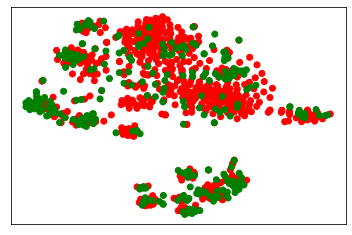

In [15]:
colors = {0:'red', 1:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'],
            c=for_tsne_df['Score'].apply(lambda x: colors[x]))

plt.xticks([])
plt.yticks([])
plt.show()

#### 加入合成資料後

Dimension of original data is 16168,
Dimension of embedded data is 2.


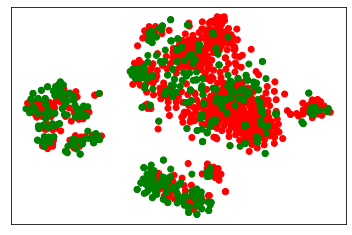

In [16]:
tsne = manifold.TSNE(n_components=2, init='random', random_state=501)
X_tsne = tsne.fit_transform(X_smo)

print("Dimension of original data is {},\n"
      "Dimension of embedded data is {}.".format(X_smo.shape[-1], X_tsne.shape[-1]))

'''嵌入空間視覺化'''
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

for_tsne = np.vstack((X_norm.T, y_smo)).T

for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x', 'Dimension_y', 'Score'])

colors = {0:'red', 1:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'],
            c=for_tsne_df['Score'].apply(lambda x: colors[x]))

plt.xticks([])
plt.yticks([])
plt.show()

In [17]:
CMAP = "copper"
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import seaborn as sns

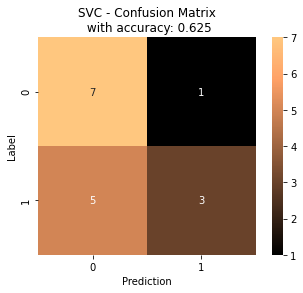

In [18]:
SVC_Model = SVC()
SVC_Model.fit(X_smo, y_smo)
# SVC_Model.fit(GDSC_TCGA_D_train_data, GDSC_TCGA_D_train_data_label)
SVC_result = SVC_Model.predict(P_TCGA_D_wo_label)
SVC_score = SVC_Model.score(P_TCGA_D_wo_label, P_TCGA_D_label)
SVC_score = np.around(SVC_score, decimals=3)

SVC_cm = confusion_matrix(P_TCGA_D_label, SVC_result)
sns.heatmap(SVC_cm, square=True, annot=True, cmap=CMAP, cbar=True, fmt="")
SVC_plot = plt.xlabel("Prediction")
SVC_plot = plt.ylabel("Label")
SVC_plot = plt.title(f"SVC - Confusion Matrix\n with accuracy: {SVC_score}")

plt.show(SVC_plot)

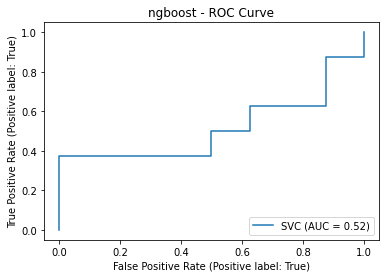

In [48]:
from sklearn import metrics
metrics.plot_roc_curve(SVC_Model, P_TCGA_D_wo_label, P_TCGA_D_label)
plt.title("ngboost - ROC Curve")
plt.show()

----
### E-2. 使用 Adaboost 訓練


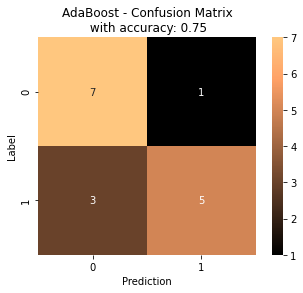

In [19]:
from sklearn.ensemble import AdaBoostClassifier

AdaBoost_Model = AdaBoostClassifier()
AdaBoost_Model.fit(X_smo, y_smo)
AdaBoost_result = AdaBoost_Model.predict(P_TCGA_D_wo_label)
AdaBoost_score = AdaBoost_Model.score(P_TCGA_D_wo_label, P_TCGA_D_label)
AdaBoost_score = np.around(AdaBoost_score, decimals=3)

AdaBoost_cm = confusion_matrix(P_TCGA_D_label, AdaBoost_result)
sns.heatmap(AdaBoost_cm, square=True, annot=True, cmap=CMAP, cbar=True, fmt="")
AdaBoost_plot = plt.xlabel("Prediction")
AdaBoost_plot = plt.ylabel("Label")
AdaBoost_plot = plt.title(f"AdaBoost - Confusion Matrix\n with accuracy: {AdaBoost_score}")
plt.show(AdaBoost_plot)

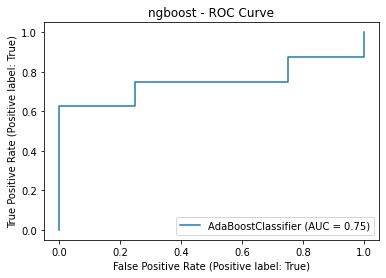

In [47]:
from sklearn import metrics
metrics.plot_roc_curve(AdaBoost_Model, P_TCGA_D_wo_label, P_TCGA_D_label)
plt.title("ngboost - ROC Curve")
plt.show()

----
### E-3. 使用 KNN 訓練

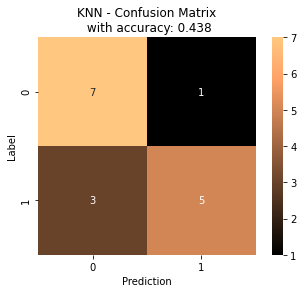

In [20]:
from sklearn.neighbors import KNeighborsClassifier
KNN_Model = KNeighborsClassifier(n_neighbors=3)

KNN_Model.fit(X_smo, y_smo)
KNN_result = KNN_Model.predict(P_TCGA_D_wo_label)
KNN_score = KNN_Model.score(P_TCGA_D_wo_label, P_TCGA_D_label)
KNN_score = np.around(KNN_score, decimals=3)
KNN_cm = confusion_matrix(P_TCGA_D_label, KNN_result)
sns.heatmap(AdaBoost_cm, square=True, annot=True, cmap=CMAP, cbar=True, fmt="")
KNN_plot = plt.xlabel("Prediction")
KNN_plot = plt.ylabel("Label")
KNN_plot = plt.title(f"KNN - Confusion Matrix\n with accuracy: {KNN_score}")

plt.show(KNN_plot)

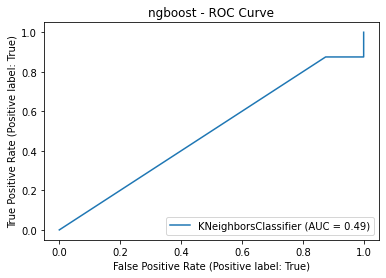

In [46]:
from sklearn import metrics
metrics.plot_roc_curve(KNN_Model, P_TCGA_D_wo_label, P_TCGA_D_label)
plt.title("ngboost - ROC Curve")
plt.show()

----
### E-4. 使用 Gaussian Naive Bayes 訓練

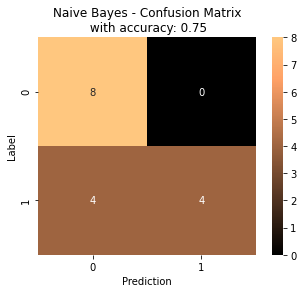

In [21]:
from sklearn.naive_bayes import GaussianNB

NB_Model = GaussianNB()

NB_Model.fit(X_smo, y_smo)
NB_score = NB_Model.score(P_TCGA_D_wo_label, P_TCGA_D_label)
NB_score = np.around(NB_score, decimals=3)
NB_result = NB_Model.predict(P_TCGA_D_wo_label)

NB_cm = confusion_matrix(P_TCGA_D_label, NB_result)
sns.heatmap(NB_cm, square=True, annot=True, cmap=CMAP, cbar=True, fmt="")
NB_plot = plt.xlabel("Prediction")
NB_plot = plt.ylabel("Label")
NB_plot = plt.title(f"Naive Bayes - Confusion Matrix\n with accuracy: {NB_score}")
plt.show(NB_plot)

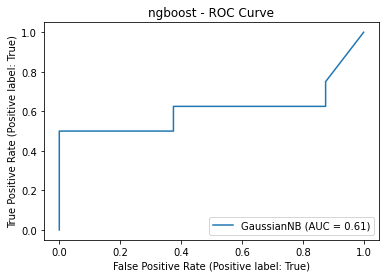

In [45]:
from sklearn import metrics
metrics.plot_roc_curve(NB_Model, P_TCGA_D_wo_label, P_TCGA_D_label)
plt.title("ngboost - ROC Curve")
plt.show()

----

### E-5. 使用 ngboost 訓練

In [22]:
y_smo = np.asarray(y_smo, dtype=int)
y_smo

array([0, 0, 0, ..., 1, 1, 1])

[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.3683 val_loss=0.0000 scale=2.0000 norm=2.9684
[iter 200] loss=0.2694 val_loss=0.0000 scale=1.0000 norm=1.3548
[iter 300] loss=0.2329 val_loss=0.0000 scale=1.0000 norm=1.3091
[iter 400] loss=0.2103 val_loss=0.0000 scale=1.0000 norm=1.2804


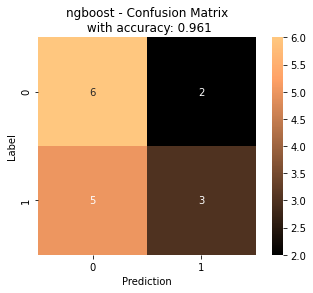

In [23]:
from ngboost import NGBClassifier

ngb_Model = NGBClassifier()
ngb_Model.fit(X_smo, y_smo)
ngb_score = ngb_Model.score(P_TCGA_D_wo_label, P_TCGA_D_label)
ngb_score = np.around(ngb_score, decimals=3)
ngb_result = ngb_Model.predict(P_TCGA_D_wo_label)

ngb_cm = confusion_matrix(P_TCGA_D_label, ngb_result)
sns.heatmap(ngb_cm, square=True, annot=True, cmap=CMAP, cbar=True, fmt="")
ngb_plot = plt.xlabel("Prediction")
ngb_plot = plt.ylabel("Label")
ngb_plot = plt.title(f"ngboost - Confusion Matrix\n with accuracy: {ngb_score}")
plt.show(ngb_plot)


In [51]:
ngb_score = ngb_Model.score(X_smo, y_smo)
print(ngb_score)

0.1946863026076375


In [44]:
from sklearn import metrics
metrics.plot_roc_curve(ngb_Model, X_smo, y_smo)
plt.title("ngboost - ROC Curve")
plt.show()

ValueError: NGBClassifier should be a binary classifier